https://www.tensorflow.org/tutorials/structured_data/preprocessing_layers?hl=ko

In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import tensorflow as tf
%matplotlib inline

np.random.seed(3)
tf.random.set_seed(3)

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [2]:
pre = pd.read_csv('kd_data_1226.csv')

pre_df = pd.DataFrame(pre)

pre_df

,person_id,gender,age_1,age_2,age_3,age_4,age_5,age_6,age_7,age_8,...,Malignant neoplastic disease,Chronic liver disease,chronic obstructive lung disease,cerebrovascular disease,chronic kidney disease,Diabetes mellitus,Ischemic heart disease,hyperlipidemia,Hypertensive disorder,cancer
0,1673221,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,1289235,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
2,1690134,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
3,530465,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
4,737827,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
404,1756845,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
405,14298,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
406,1646575,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
407,352251,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
pre_df.columns = ['person_id', 'gender', 'age_1', 'age_2', 'age_3', 'age_4', 'age_5',
       'age_6', 'age_7', 'age_8', 'smoking_status_0.0', 'smoking_status_1.0',
       'smoking_status_2.0', 'smoking_status_3.0', 'bmi_1.0', 'bmi_2.0', 'bmi_3.0',
       'bmi_4.0', 'Malignant_neoplastic_disease', 'Chronic_liver_disease',
       'chronic_obstructive_lung_disease', 'cerebrovascular_disease',
       'chronic_kidney_disease', 'Diabetes_mellitus', 'Ischemic_heart_disease',
       'hyperlipidemia', 'Hypertensive_disorder', 'cancer'] 

In [4]:
pre_df.columns

Index(['person_id', 'gender', 'age_1', 'age_2', 'age_3', 'age_4', 'age_5',
       'age_6', 'age_7', 'age_8', 'smoking_status_0.0', 'smoking_status_1.0',
       'smoking_status_2.0', 'smoking_status_3.0', 'bmi_1.0', 'bmi_2.0',
       'bmi_3.0', 'bmi_4.0', 'Malignant_neoplastic_disease',
       'Chronic_liver_disease', 'chronic_obstructive_lung_disease',
       'cerebrovascular_disease', 'chronic_kidney_disease',
       'Diabetes_mellitus', 'Ischemic_heart_disease', 'hyperlipidemia',
       'Hypertensive_disorder', 'cancer'],
      dtype='object')

In [5]:
pre_df.loc[:,list(pre_df.loc[:,pre_df.isnull().any()].columns)].isnull().sum()/(len(pre_df))*100
# 결측 확인

Series([], dtype: float64)

In [6]:
pre_df = pre_df.astype('int64')

## Input Pipeline

In [7]:
# A utility method to create a tf.data dataset from a Pandas Dataframe
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
    dataframe = dataframe.copy()
    labels = dataframe.pop('cancer')
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)

    return ds

### Train/ Test data split

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
train, test = train_test_split(pre_df, test_size=0.3, random_state=3)
#train, val = train_test_split(train, test_size=0.2, random_state=3)
print(len(train), 'train examples')
#print(len(val), 'validation examples')
print(len(test), 'test examples')

286 train examples
123 test examples


## Normalization & Metrics

In [10]:
from tensorflow.keras.layers.experimental import preprocessing

* Normalization - 데이터의 특성별 정규화입니다.
* CategoryEncoding 카테고리 인코딩 레이어입니다.
* StringLookup - 어휘의 문자열을 정수 인덱스로 매핑합니다.
* IntegerLookup - 어휘의 정수를 정수 인덱스로 매핑합니다.

In [11]:
def get_normalization_layer(name, dataset):
    # Create a Normalization layer for our feature.
    normalizer = preprocessing.Normalization()

    # Prepare a Dataset that only yields our feature.
    feature_ds = dataset.map(lambda x, y: x[name])

    # Learn the statistics of the data.
    normalizer.adapt(feature_ds)

    return normalizer

# age, bmi, egd 적용

In [12]:
def get_category_encoding_layer(name, dataset, dtype, max_tokens=None):
  # Create a StringLookup layer which will turn strings into integer indices
    if dtype == 'string':
        index = preprocessing.StringLookup(max_tokens=max_tokens)
    else:
        index = preprocessing.IntegerLookup(max_values=max_tokens)

  # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the set of possible values and assign them a fixed integer index.
    index.adapt(feature_ds)

  # Create a Discretization for our integer indices.
    encoder = preprocessing.CategoryEncoding(max_tokens=index.vocab_size())

  # Prepare a Dataset that only yields our feature.
    feature_ds = feature_ds.map(index)

  # Learn the space of possible indices.
    encoder.adapt(feature_ds)

  # Apply one-hot encoding to our indices. The lambda function captures the
  # layer so we can use them, or include them in the functional model later.
    return lambda feature: encoder(index(feature))

In [13]:
METRICS = [
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.AUC(name='auc'),
      tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

In [14]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn import metrics
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [15]:
def plot_metrics(history):
    metrics = ['loss', 'auc', 'precision', 'recall']
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
                 color=colors[1], label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
            plt.ylim([0.8,1])
        else:
            plt.ylim([0,1])

    plt.legend()

## Create Layer

In [16]:
from sklearn.metrics import roc_curve, auc, roc_auc_score 

In [17]:
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.utils import class_weight
from tensorflow.keras.utils import plot_model
from tensorflow.keras.regularizers import L1, L2, L1L2
from sklearn.utils import class_weight

In [18]:
# mini_batch
batch_size = 32
train_ds = df_to_dataset(train, batch_size=batch_size)

[(train_features, label_batch)] = train_ds.take(1)
print('Every feature:', list(train_features.keys()))
print('A batch of gender:', train_features['gender'])
print('A batch of targets:', label_batch )

Every feature: ['person_id', 'gender', 'age_1', 'age_2', 'age_3', 'age_4', 'age_5', 'age_6', 'age_7', 'age_8', 'smoking_status_0.0', 'smoking_status_1.0', 'smoking_status_2.0', 'smoking_status_3.0', 'bmi_1.0', 'bmi_2.0', 'bmi_3.0', 'bmi_4.0', 'Malignant_neoplastic_disease', 'Chronic_liver_disease', 'chronic_obstructive_lung_disease', 'cerebrovascular_disease', 'chronic_kidney_disease', 'Diabetes_mellitus', 'Ischemic_heart_disease', 'hyperlipidemia', 'Hypertensive_disorder']
A batch of gender: tf.Tensor([1 1 0 1 0 1 0 1 0 1 0 1 0 0 1 1 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1], shape=(32,), dtype=int64)
A batch of targets: tf.Tensor([0 0 0 0 1 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0 0], shape=(32,), dtype=int64)


In [19]:
batch_size = 32
train_ds = df_to_dataset(train, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)
all_ds = df_to_dataset(pre_df, shuffle=False, batch_size=batch_size)

In [20]:
[(_, label)] = train_ds.take(1)
y_label = np.array(label)

In [21]:
class_weights = class_weight.compute_class_weight('balanced',np.unique(y_label),y_label)

class_weights = {0:class_weights[0], 1:class_weights[1]}

C:\ProgramData\Anaconda32\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=[0 1], y=[1 0 0 1 0 0 1 0 1 1 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


In [22]:
#train_ds

In [23]:
categorical_cols = [ 'gender', 'age_1', 'age_2', 'age_3', 'age_4',
       'age_5', 'age_6', 'age_7', 'age_8', 'smoking_status_0.0',
       'smoking_status_1.0', 'smoking_status_2.0', 'smoking_status_3.0',
       'bmi_1.0', 'bmi_2.0', 'bmi_3.0', 'bmi_4.0',
       'Malignant_neoplastic_disease', 'Chronic_liver_disease',
       'chronic_obstructive_lung_disease', 'cerebrovascular_disease',
       'chronic_kidney_disease', 'Diabetes_mellitus',
       'Ischemic_heart_disease', 'hyperlipidemia', 'Hypertensive_disorder']

In [24]:
all_inputs = []
encoded_features = []

# Numeric features.
for header in categorical_cols:
    
    if len(pre_df[header].unique())==1:
        numeric_col = tf.keras.Input(shape=(1,), name=header)
        normalization_layer = get_normalization_layer(header, train_ds)
        encoded_numeric_col = normalization_layer(numeric_col)
        all_inputs.append(numeric_col)
        encoded_features.append(encoded_numeric_col)
    
    else:
        categorical_col = tf.keras.Input(shape=(1,), name=header,dtype='int64')
        encoding_layer = get_category_encoding_layer(header, train_ds,dtype='int64')
        encoded_categorical_col = encoding_layer(categorical_col)
        all_inputs.append(categorical_col)
        encoded_features.append(encoded_categorical_col)

    print(header)

gender
age_1
age_2
age_3
age_4
age_5
age_6
age_7
age_8
smoking_status_0.0
smoking_status_1.0
smoking_status_2.0
smoking_status_3.0
bmi_1.0
bmi_2.0
bmi_3.0
bmi_4.0
Malignant_neoplastic_disease
Chronic_liver_disease
chronic_obstructive_lung_disease
cerebrovascular_disease
chronic_kidney_disease
Diabetes_mellitus
Ischemic_heart_disease
hyperlipidemia
Hypertensive_disorder


In [25]:
#def create_model(): #, kernel_regularizer=L2(0.001)
all_features = tf.keras.layers.concatenate(encoded_features)
x = tf.keras.layers.Dense(256, activation="relu")(all_features)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.Dense(128, activation="relu")(x)
#x = tf.keras.layers.Dropout(0.05)(x)
x = tf.keras.layers.Dense(64, activation="relu")(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.Dense(32, activation="relu")(x)
#x = tf.keras.layers.Dropout(0.05)(x)
x = tf.keras.layers.Dense(16, activation="relu")(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.Dense(8, activation="relu")(x)
#x = tf.keras.layers.Dropout(0.1)(x)
#x = tf.keras.layers.Dense(8, activation="relu")(x)
#x = tf.keras.layers.Dropout(0.1)(x)
#x = tf.keras.layers.Dense(8, activation="relu")(x)
#x = tf.keras.layers.Dropout(0.1)(x)
output = tf.keras.layers.Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(all_inputs, output)
model.compile(optimizer='rmsprop',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=METRICS)

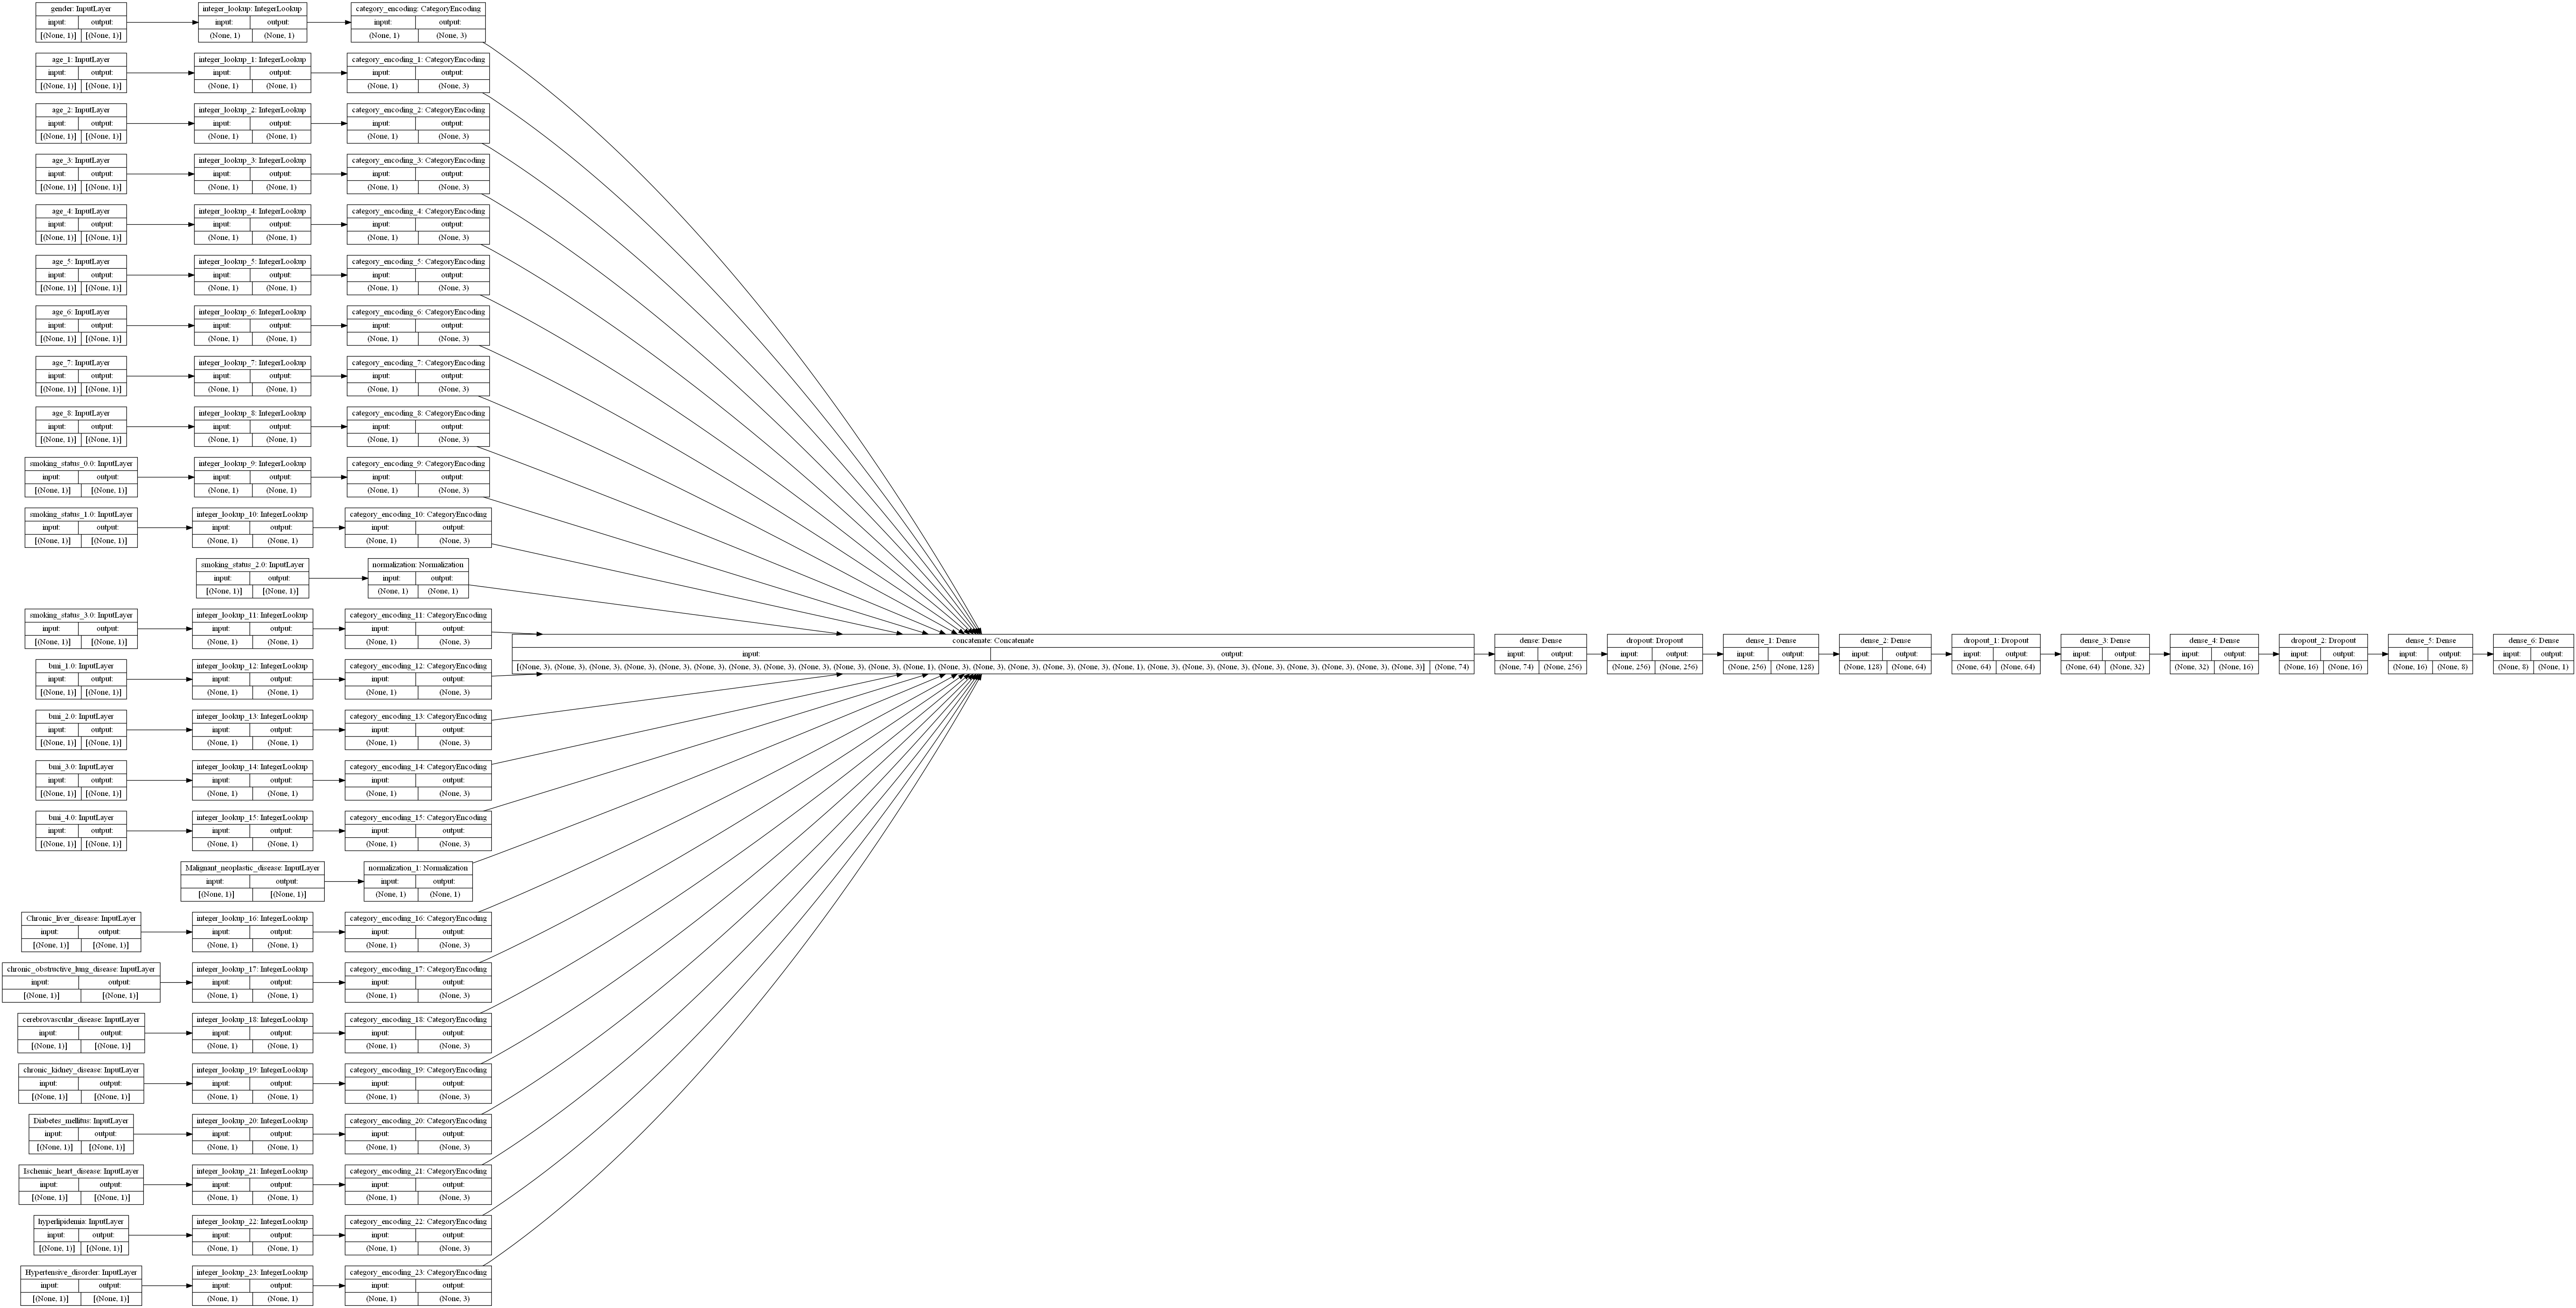

In [26]:
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")#, to_file='./model.png')

In [27]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [28]:
history = model.fit(train_ds, epochs=100, validation_data=test_ds,callbacks=[early_stopping],class_weight = class_weights)

Epoch 1/100


C:\Users\dladu\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\functional.py:588: UserWarning: Input dict contained keys ['person_id'] which did not match any model input. They will be ignored by the model.
  warnings.warn(
C:\Users\dladu\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\backend.py:5016: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  warnings.warn(


9/9 [==============================] - 9s 318ms/step - loss: 0.6311 - recall: 0.0492 - precision: 0.1579 - tp: 3.0000 - fp: 16.0000 - tn: 209.0000 - fn: 58.0000 - accuracy: 0.7413 - auc: 0.5082 - prc: 0.2035 - val_loss: 0.6267 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 95.0000 - val_fn: 28.0000 - val_accuracy: 0.7724 - val_auc: 0.8716 - val_prc: 0.6679
Epoch 2/100
9/9 [==============================] - 0s 11ms/step - loss: 0.6148 - recall: 0.0656 - precision: 0.1600 - tp: 4.0000 - fp: 21.0000 - tn: 204.0000 - fn: 57.0000 - accuracy: 0.7273 - auc: 0.6348 - prc: 0.2710 - val_loss: 0.5438 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 95.0000 - val_fn: 28.0000 - val_accuracy: 0.7724 - val_auc: 0.8803 - val_prc: 0.7073
Epoch 3/100
9/9 [==============================] - 0s 8ms/step - loss: 0.5821 - recall: 0.0656 - precision: 0.1818 - tp: 4.0000 - fp: 18.0000 - tn: 207.000

In [29]:
#model.save('kd_0110')

In [30]:
#plot_metrics(history)

In [31]:
config = model.get_config()

In [32]:
testing = df_to_dataset(test, batch_size=len(test),shuffle=False)

mets = model.evaluate(testing)

#print("Loss", mets[0])
print("Accuracy", mets[5])
print("AUC", mets[8])

In [33]:
results = model.evaluate(testing)
for name, value in zip(model.metrics_names, results):
    print(name, ': ', value)

1/1 [==============================] - 0s 100ms/step - loss: 0.3358 - recall: 0.5000 - precision: 0.8750 - tp: 14.0000 - fp: 2.0000 - tn: 93.0000 - fn: 14.0000 - accuracy: 0.8699 - auc: 0.9030 - prc: 0.7324
loss :  0.3358036279678345
recall :  0.5
precision :  0.875
tp :  14.0
fp :  2.0
tn :  93.0
fn :  14.0
accuracy :  0.869918704032898
auc :  0.9030075073242188
prc :  0.732367753982544


In [34]:
pred = model.predict(testing)
pred = [ 1 if x >= 0.5 else 0 for x in pred]


[(_, label)] = testing.take(1)
print(confusion_matrix(label,pred,labels=[1,0]))
print(classification_report(label,pred))

[[14 14]
 [ 2 93]]
              precision    recall  f1-score   support

           0       0.87      0.98      0.92        95
           1       0.88      0.50      0.64        28

    accuracy                           0.87       123
   macro avg       0.87      0.74      0.78       123
weighted avg       0.87      0.87      0.86       123

